In [1]:
import cv2 as cv 
import numpy as np
import scipy
import PIL.Image
import math
import caffe
import time
from config_reader import config_reader
import util

In [2]:
test_image = '../sample_image/ski.jpg'
#test_image = '../sample_image/upper.jpg'
#test_image = '../sample_image/upper2.jpg'
oriImg = cv.imread(test_image) # B,G,R order

In [8]:
param, model = config_reader()
print param
print model
param['scale_search'] = [1.0]
multiplier = [x * model['boxsize'] / oriImg.shape[0] for x in param['scale_search']]
print multiplier

{'use_gpu': 1, 'GPUdeviceNumber': 0, 'modelID': '1', 'octave': 3, 'starting_range': 0.8, 'ending_range': 2.0, 'scale_search': [0.5, 1.0, 1.5, 2.0], 'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5, 'min_num': 4, 'mid_num': 10, 'crop_ratio': 2.5, 'bbox_ratio': 0.25}
{'caffemodel': '../../model/_trained_COCO/pose_iter_440000.caffemodel', 'deployFile': '../../model/_trained_COCO/pose_deploy.prototxt', 'description': 'COCO Pose56 Two-level Linevec', 'boxsize': 368, 'padValue': 128, 'np': '12', 'stride': 8, 'part_str': ['[nose', 'neck', 'Rsho', 'Relb', 'Rwri', 'Lsho', 'Lelb', 'Lwri', 'Rhip', 'Rkne', 'Rank', 'Lhip', 'Lkne', 'Lank', 'Leye', 'Reye', 'Lear', 'Rear', 'pt19]']}
[0.5459940652818991]


In [9]:
if param['use_gpu']: 
    caffe.set_mode_gpu()
    caffe.set_device(param['GPUdeviceNumber']) # set to your device!
else:
    caffe.set_mode_cpu()
net = caffe.Net(model['deployFile'], model['caffemodel'], caffe.TEST)

In [10]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
heatmap_list = []
paf_list = []

for m in range(len(multiplier)):
    scale = multiplier[m]
    print scale
    imageToTest = cv.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model['stride'], model['padValue'])
    print imageToTest_padded.shape

    net.blobs['data'].reshape(*(1, 3, imageToTest_padded.shape[0], imageToTest_padded.shape[1]))
    #net.forward() # dry run
    net.blobs['data'].data[...] = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))/256 - 0.5;
    start_time = time.time()
    output_blobs = net.forward()
    print('At scale %d, The CNN took %.2f ms.' % (m, 1000 * (time.time() - start_time)))

    # extract outputs, resize, and remove padding
    heatmap = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[1]].data), (1,2,0)) # output 1 is heatmaps
    heatmap = cv.resize(heatmap, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)
    
    paf = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[0]].data), (1,2,0)) # output 0 is PAFs
    paf = cv.resize(paf, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)
     
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)
    heatmap_list.append(heatmap)
    paf_list.append(paf)


0.545994065282
(368, 392, 3)
At scale 0, The CNN took 1641.55 ms.


In [11]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]

In [12]:
heatmap_avg_bak = heatmap_avg
paf_bak =paf

In [13]:
print heatmap_avg_bak.shape
print heatmap_list[0].shape

(674, 712, 19)
(674, 712, 19)


In [16]:
from scipy.ndimage.filters import gaussian_filter

# m=1
# heatmap_avg = heatmap_list[part_m]
# paf = paf_list[part_m]
heatmap_avg = heatmap_avg_bak
paf = paf_bak
for part_m in range(len(multiplier)):
    heatmap_avg = heatmap_list[part_m]
    paf = paf_list[part_m]
    
    all_peaks = []
    all_peaks_lst = []
    peak_counter = 0

    for part in range(19-1):
        x_list = []
        y_list = []
        map_ori = heatmap_avg[:,:,part]
        map = gaussian_filter(map_ori, sigma=3)

        map_left = np.zeros(map.shape)
        map_left[1:,:] = map[:-1,:]
        map_right = np.zeros(map.shape)
        map_right[:-1,:] = map[1:,:]
        map_up = np.zeros(map.shape)
        map_up[:,1:] = map[:,:-1]
        map_down = np.zeros(map.shape)
        map_down[:,:-1] = map[:,1:]

        peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
        peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
        all_peaks_lst += peaks
        peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
        id = range(peak_counter, peak_counter + len(peaks))
        peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)


    connection_all = []
    special_k = []
    mid_num = 10

    for k in range(len(mapIdx)):
        score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
        candA = all_peaks[limbSeq[k][0]-1]
        candB = all_peaks[limbSeq[k][1]-1]
        nA = len(candA)
        nB = len(candB)
        indexA, indexB = limbSeq[k]
        if(nA != 0 and nB != 0):
            connection_candidate = []
            for i in range(nA):
                for j in range(nB):
                    vec = np.subtract(candB[j][:2], candA[i][:2])
                    norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                    vec = np.divide(vec, norm)

                    startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                   np.linspace(candA[i][1], candB[j][1], num=mid_num))

                    vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                      for I in range(len(startend))])
                    vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                      for I in range(len(startend))])

                    score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                    score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                    criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                    criterion2 = score_with_dist_prior > 0
                    if criterion1 and criterion2:
                        connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

            connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
            connection = np.zeros((0,5))
            for c in range(len(connection_candidate)):
                i,j,s = connection_candidate[c][0:3]
                if(i not in connection[:,3] and j not in connection[:,4]):
                    connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                    if(len(connection) >= min(nA, nB)):
                        break

            connection_all.append(connection)
        else:
            special_k.append(k)
            connection_all.append([])

    # last number in each row is the total parts number of that person
    # the second last number in each row is the score of the overall configuration
    subset = -1 * np.ones((0, 20))
    candidate = np.array([item for sublist in all_peaks for item in sublist])

    for k in range(len(mapIdx)):
        if k not in special_k:
            partAs = connection_all[k][:,0]
            partBs = connection_all[k][:,1]
            indexA, indexB = np.array(limbSeq[k]) - 1

            for i in range(len(connection_all[k])): #= 1:size(temp,1)
                found = 0
                subset_idx = [-1, -1]
                for j in range(len(subset)): #1:size(subset,1):
                    if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                        subset_idx[found] = j
                        found += 1

                if found == 1:
                    j = subset_idx[0]
                    if(subset[j][indexB] != partBs[i]):
                        subset[j][indexB] = partBs[i]
                        subset[j][-1] += 1
                        subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                elif found == 2: # if found 2 and disjoint, merge them
                    j1, j2 = subset_idx
                    print "found = 2"
                    membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                    if len(np.nonzero(membership == 2)[0]) == 0: #merge
                        subset[j1][:-2] += (subset[j2][:-2] + 1)
                        subset[j1][-2:] += subset[j2][-2:]
                        subset[j1][-2] += connection_all[k][i][2]
                        subset = np.delete(subset, j2, 0)
                    else: # as like found == 1
                        subset[j1][indexB] = partBs[i]
                        subset[j1][-1] += 1
                        subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(20)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    row[-1] = 2
                    row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                    subset = np.vstack([subset, row])



        # delete some rows of subset which has few parts occur
    deleteIdx = [];
    for i in range(len(subset)):
        if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
            deleteIdx.append(i)
    subset = np.delete(subset, deleteIdx, axis=0)



    human_grid = []
    for human_i in subset:
        human_grid_i = []
        for i in range(18):
            body_part_index = int(human_i[i])
            if body_part_index == -1:
                grid = (0, 0)
            else:
                grid = all_peaks_lst[body_part_index]
            human_grid_i += [grid[0], grid[1]]
        human_grid.append(human_grid_i)
    all_grid = np.array(human_grid)
    print all_grid.shape
    print human_grid

(5, 36)
[[68, 269, 67, 302, 39, 302, 64, 343, 93, 357, 96, 301, 123, 331, 102, 352, 36, 390, 79, 348, 116, 405, 81, 387, 115, 340, 0, 0, 62, 262, 76, 263, 50, 268, 83, 269], [172, 281, 169, 304, 139, 305, 138, 357, 168, 378, 200, 305, 202, 351, 196, 374, 153, 378, 142, 379, 172, 402, 192, 375, 240, 364, 167, 408, 166, 273, 180, 274, 156, 273, 190, 277], [302, 78, 305, 113, 272, 118, 258, 167, 0, 0, 339, 111, 352, 146, 0, 0, 298, 213, 311, 282, 324, 367, 340, 209, 345, 278, 295, 344, 295, 71, 308, 70, 284, 77, 317, 74], [614, 44, 615, 83, 584, 90, 547, 131, 571, 176, 645, 77, 657, 123, 661, 165, 612, 202, 618, 281, 615, 360, 650, 196, 648, 279, 636, 355, 606, 38, 620, 36, 595, 45, 631, 38], [479, 97, 459, 143, 416, 144, 345, 142, 295, 170, 502, 140, 540, 189, 0, 0, 442, 321, 509, 434, 532, 566, 458, 315, 462, 460, 409, 563, 466, 86, 488, 85, 438, 92, 0, 0]]


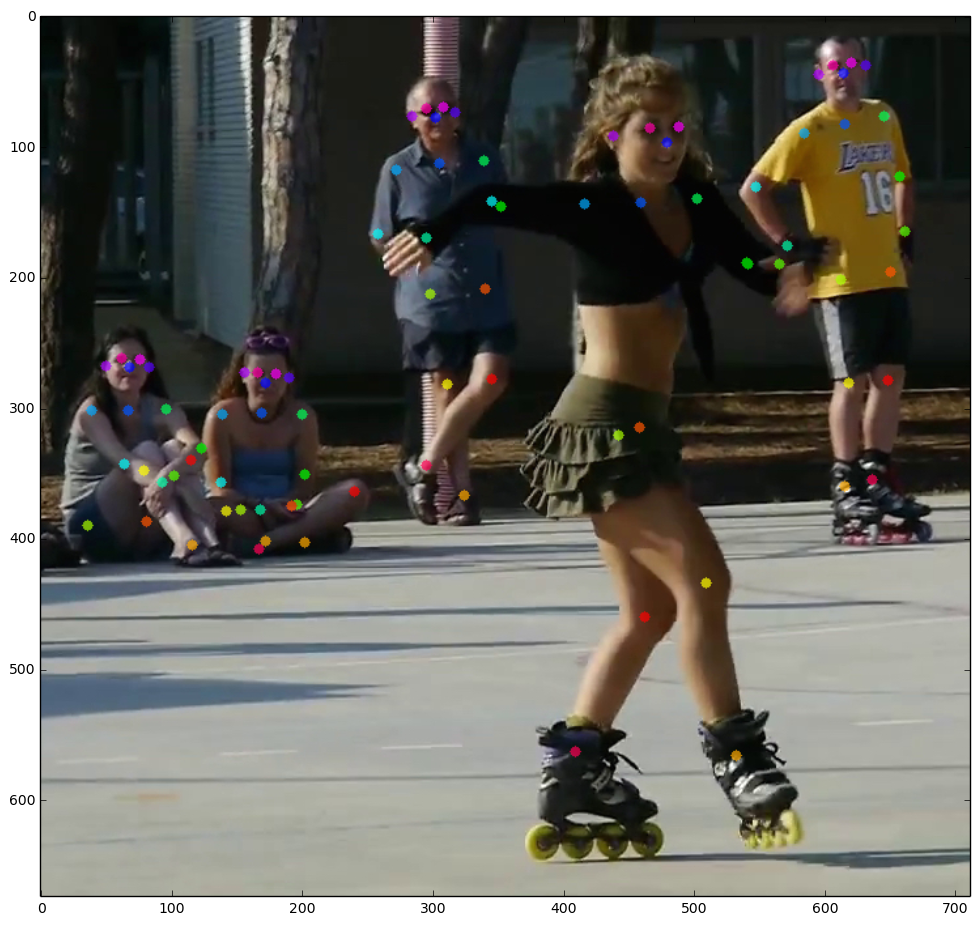

In [18]:
import copy
import matplotlib
%matplotlib inline
import pylab as plt

# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv.imread(test_image) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

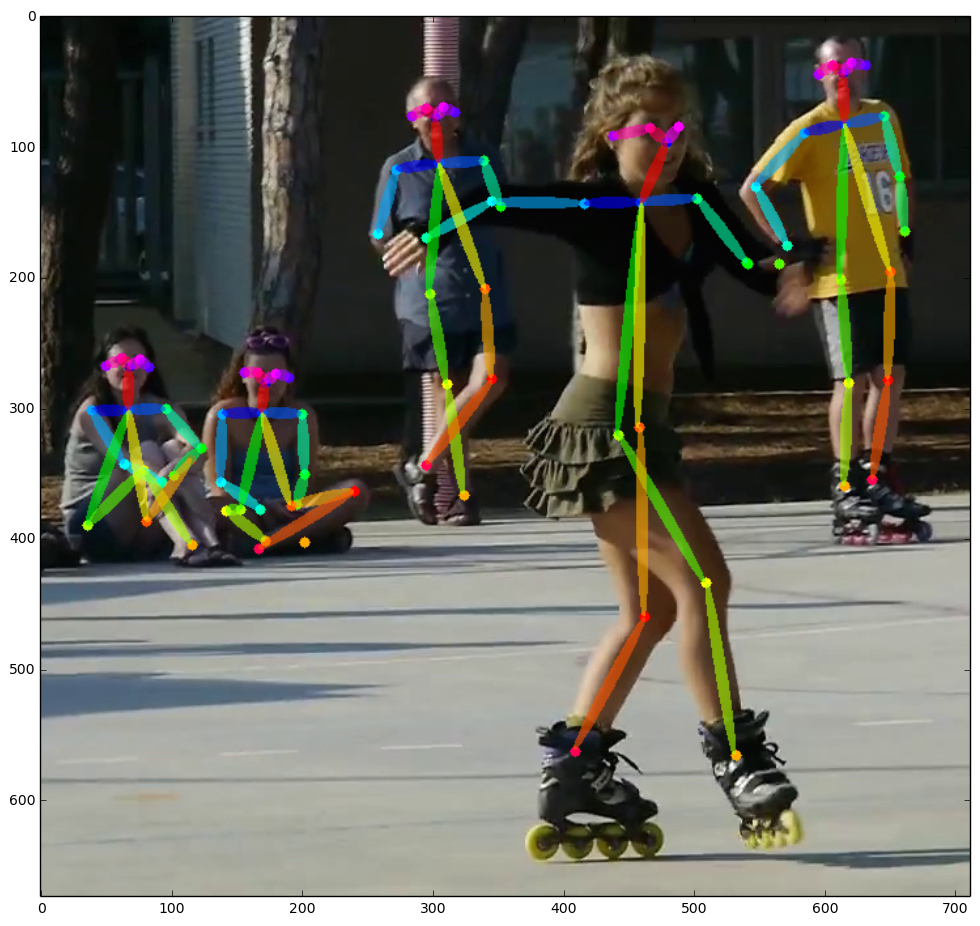

In [19]:
# visualize 2
stickwidth = 4

for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)